In [218]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("..")

# import numpy as np
# import numpy.linalg as LA
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import control

import autograd.numpy as np
import autograd.numpy.linalg as LA
from autograd import grad

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Simulate Nonlinear System

Simulate a thrust-vectored drone
<center>
<img src="../doc/ekf/thrust-vector-diagram.png" alt="Diagram" style="width: 300px" />
</center>

$
\left\{ \begin{aligned}
\dot{x}\  &= \ v_x \\
\dot{y}\  &= \ v_y \\
\dot{\theta}\ &= \ \omega \\
\dot v_x  &= \ \cos{(\theta + \alpha)}\ T \\
\dot v_y  &= \ \sin{(\theta + \alpha)}\ T \\
\dot{\omega}\ &= -\sin \alpha\ T
\end{aligned} \right.
$


In [267]:
# Form linear system x_dot = Ax + Bu
def eqn(t,y,ref):
    """ Thrust vectored drone """
    # Unpack state
    theta = y[2]
    omega = y[3]
    
    # Unpack control input
    u = ref(t)
    alpha = u[0]
    T = np.array([1])
    
    dydt = np.zeros(4)
    dydt[0] = np.cos(theta + alpha) * T**2 #+ 0.2*np.random.rand()
    dydt[1] = np.sin(theta + alpha) * T**2 #+ 0.2*np.random.rand()
    dydt[2] = omega
    dydt[3] = -np.sin(alpha) * T
    
    return dydt

def simulate_system(t_span, ref, Ts, y0=None):
    y0 = np.zeros(4)
    
    # Set ODE parameters
    t_eval = np.arange(t_span[0], t_span[1], Ts)
    
    # Simulate system by solving ODE
    sol = solve_ivp(eqn, t_span, y0, t_eval=t_eval, args=(ref,))
    
    return sol.t, sol.y, ref(sol.t)

def ref_sine(t):
    alpha = 2*( np.sin(t) - np.sin(3*t) ).reshape((-1))
    ref = np.stack([ alpha, np.ones_like(alpha) ])
    return ref

In [271]:
N = 4
Ts = 1/100

t, y_true, u_true = simulate_system([0,10], ref_sine, Ts)

# Add noise
y = y_true + np.random.randn(*y_true.shape) * np.array([0.1, 0.1, 0.1, 0.01]).reshape(-1,1)
u = u_true + 0 * np.random.randn(*u_true.shape)

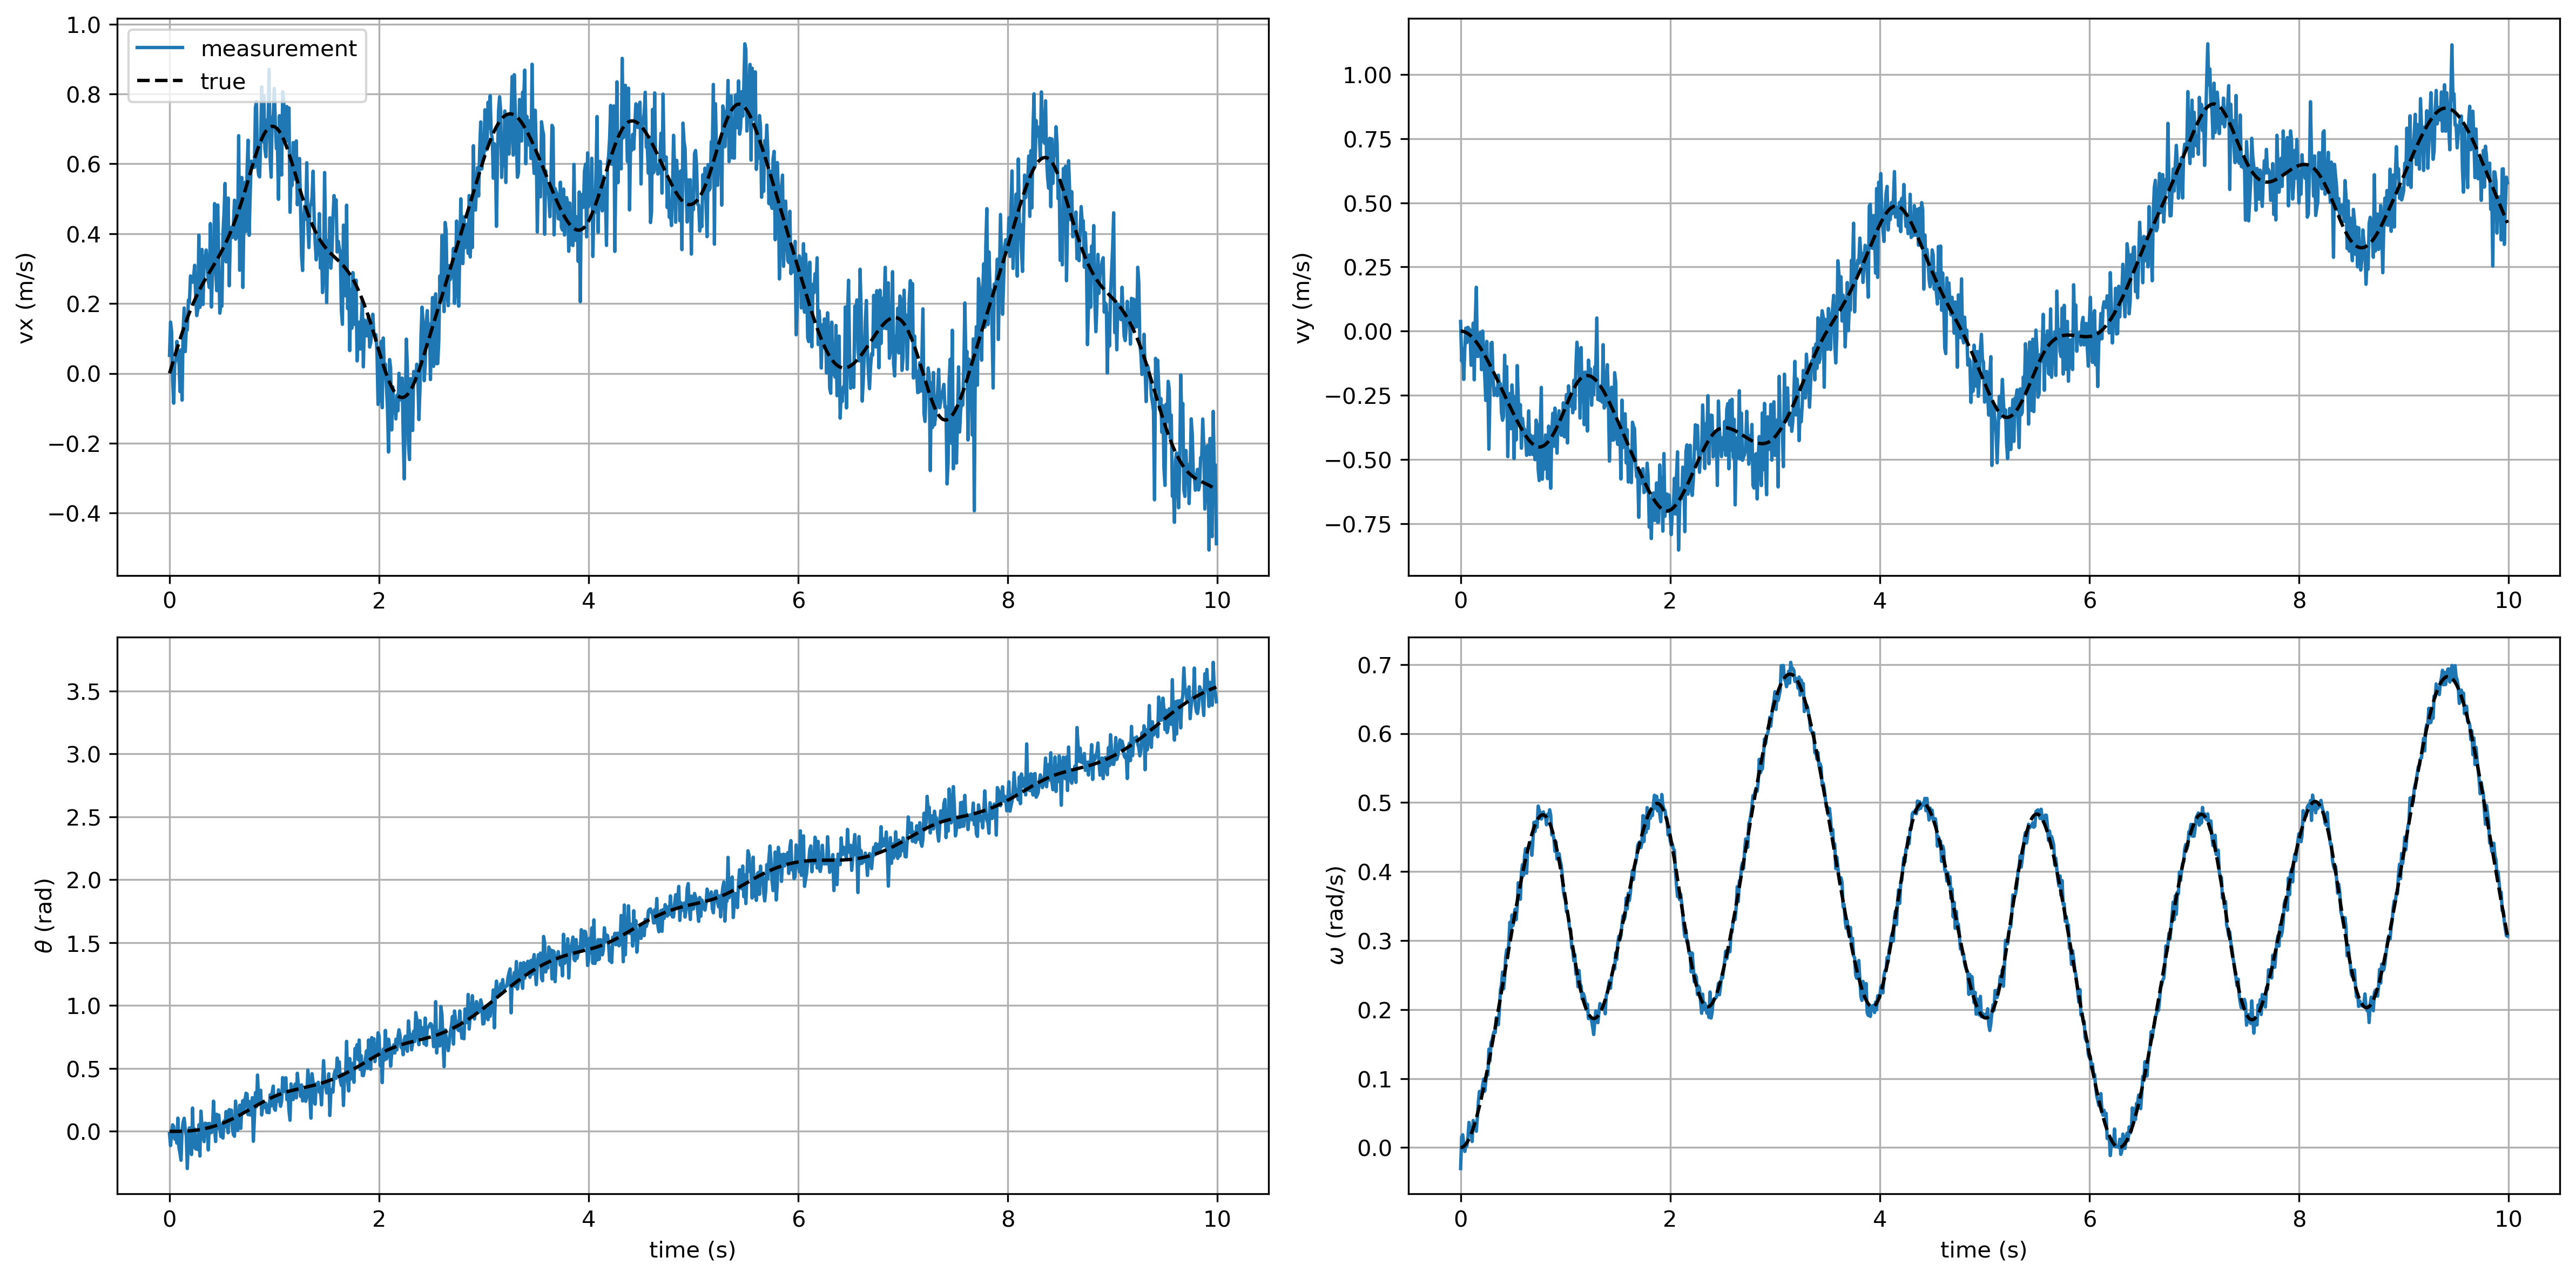

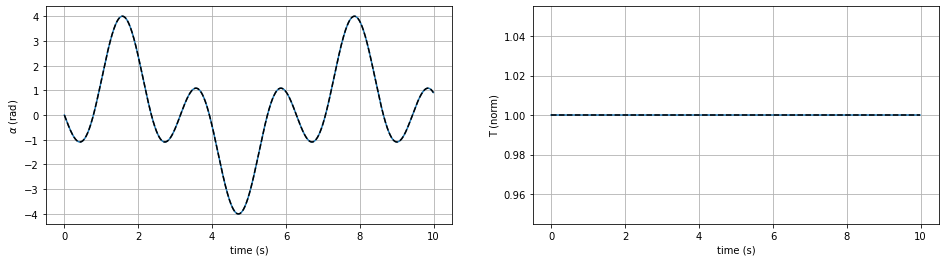

In [281]:
def plot_system(t, y, y_true, estimate1=None, estimate2=None, lgd=[], dpi=None):
    fig, axes = plt.subplots(2,2, figsize=(16,8), dpi=dpi)
    ax = axes.flatten()

    labels = ['vx', 'vy', r'$\theta$', r'$\omega$']
    units  = ['m/s', 'm/s', 'rad', 'rad/s']
    for i,a in enumerate(ax):
        a.plot(t, y[i,:])
        a.plot(t, y_true[i,:], 'k--')
        if estimate1 is not None:
            a.plot(t, estimate1[i,:])
        if estimate2 is not None:
            a.plot(t, estimate2[i,:])

        a.set_ylabel(f'{labels[i]} ({units[i]})')
        # a.set_title(labels[i])
        a.grid()

    axes[0,0].legend(['measurement', 'true'] + lgd, loc='upper left')
    [ axes[1,i].set_xlabel('time (s)') for i in range(2) ]

    fig.tight_layout()

def plot_control_input(u, u_true, dpi=None):
    fig, axes = plt.subplots(1, 2, figsize=(16,4), dpi=dpi)
    ax = axes.T.flatten()

    for i,a in enumerate(ax):
        a.plot(t, u[i,:])
        a.plot(t, u_true[i,:], 'k--')
        a.grid()

    axes[0].set_ylabel(r'$\alpha$ (rad)')
    axes[1].set_ylabel('T (norm)')
    axes[0].set_xlabel('time (s)')
    axes[1].set_xlabel('time (s)')
    
plot_system(t, y, y_true, dpi=300)
plot_control_input(u, u_true)

## Initialise and Use Kalman Filter

C:\Users\andre\anaconda3\envs\control-systems\lib\site-packages\autograd\tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Wall time: 3.12 s


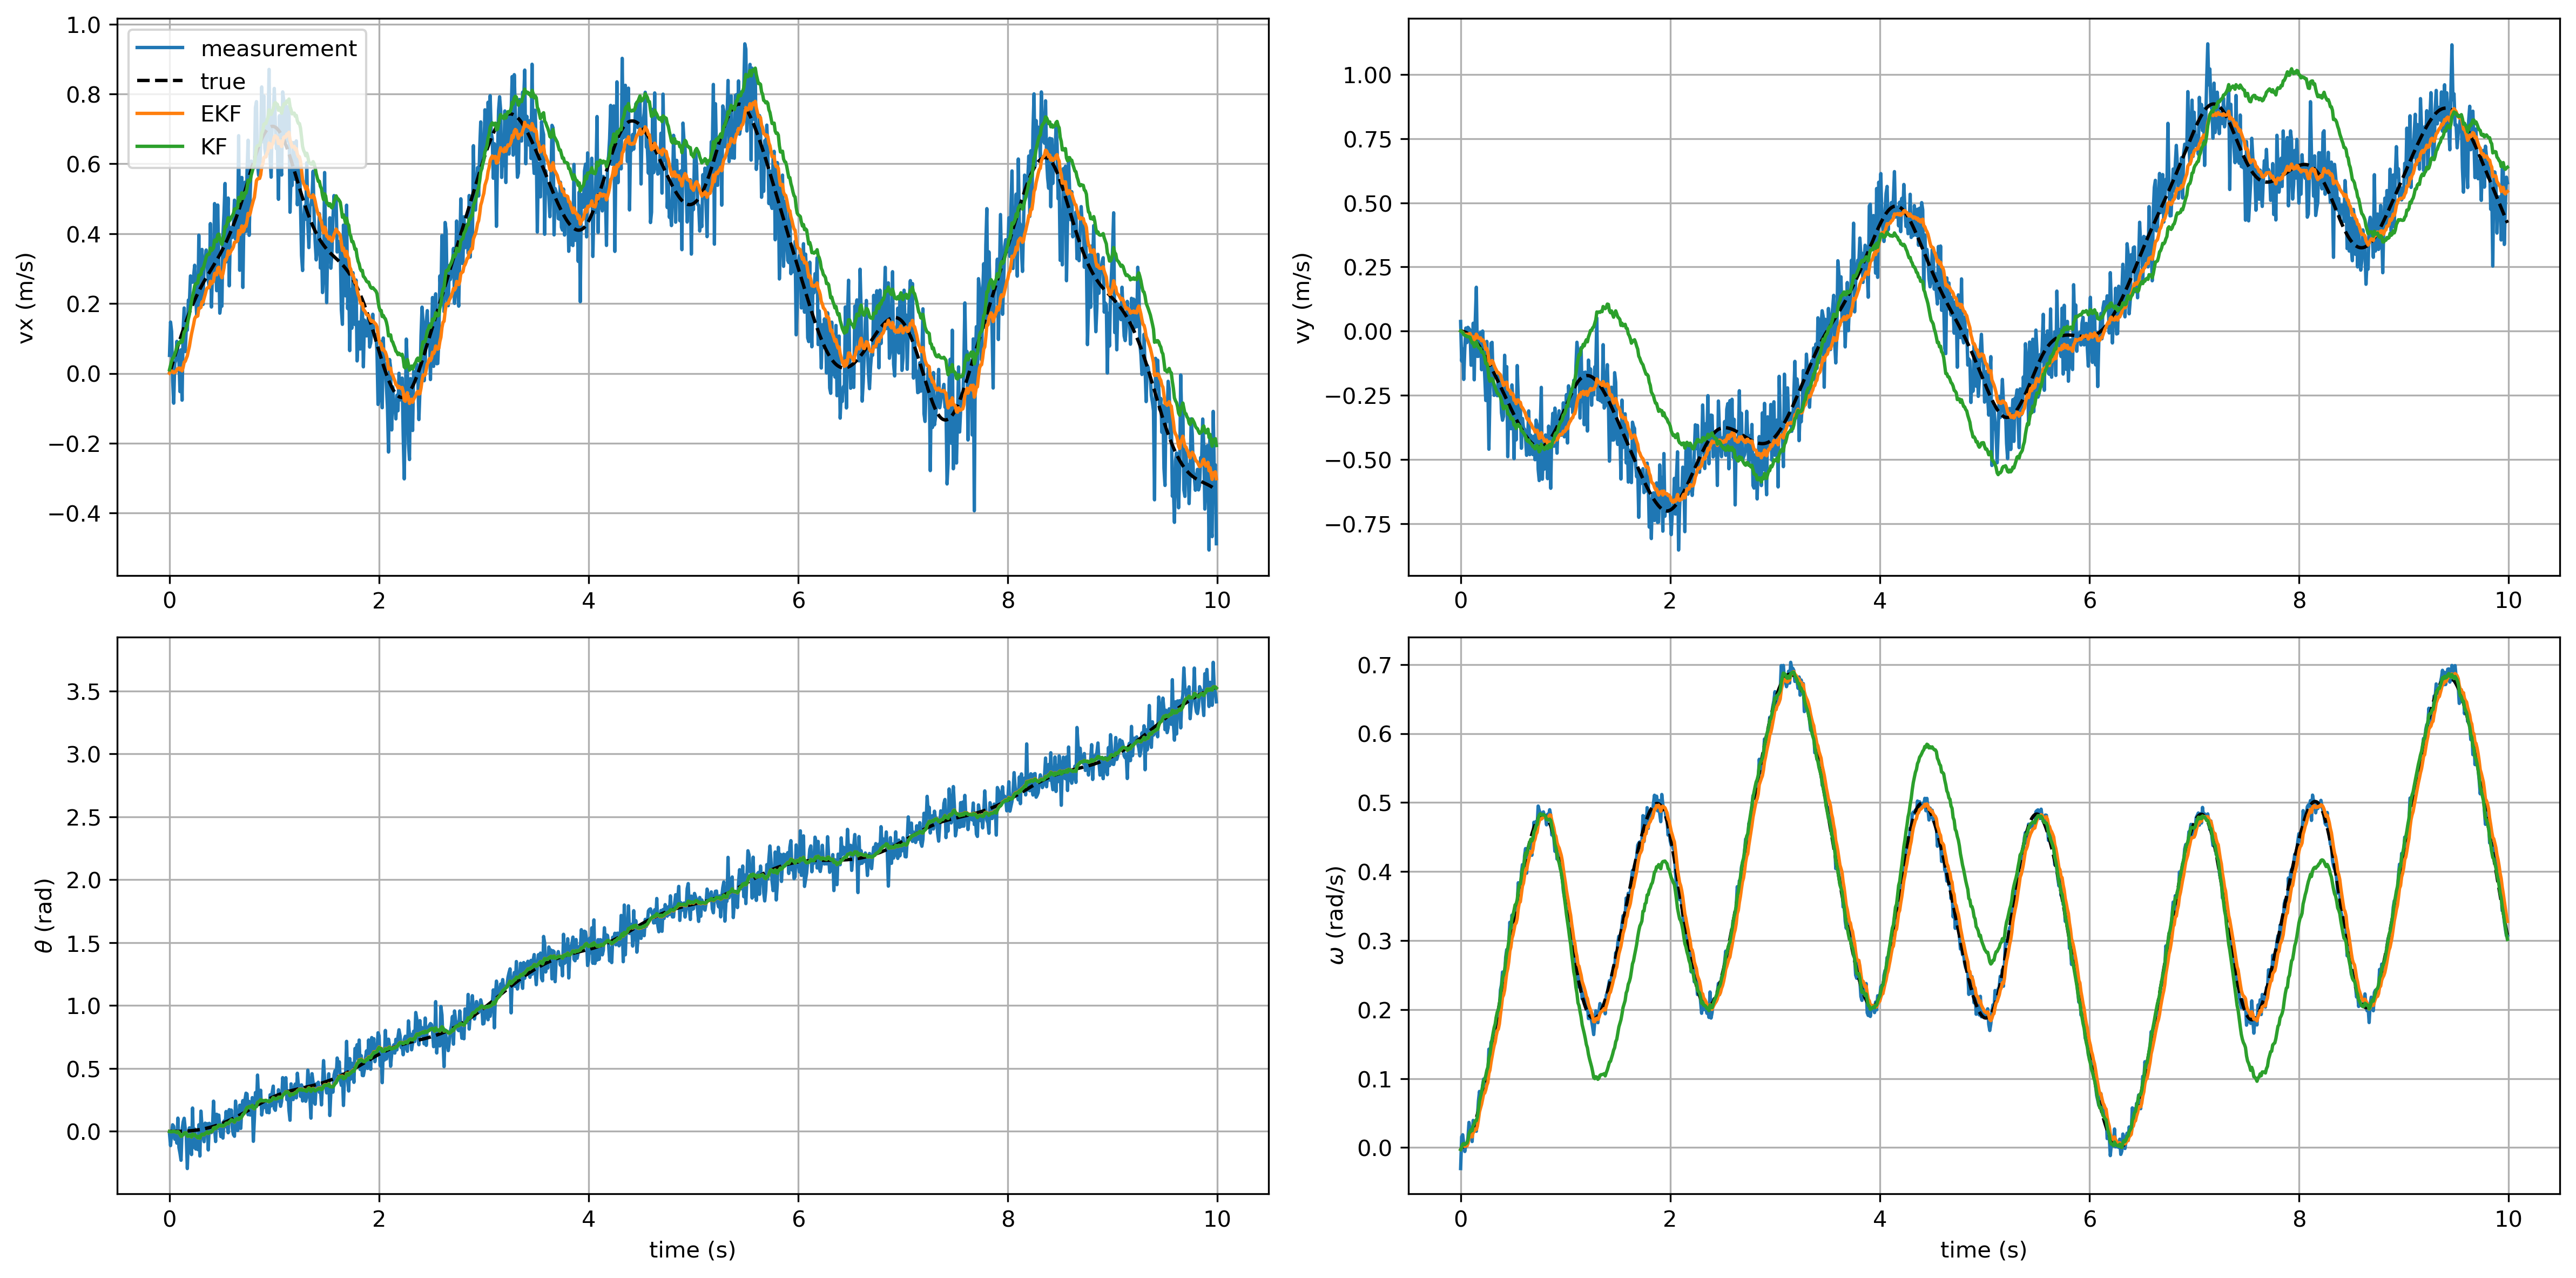

In [282]:
%%time
from estimation.KalmanFilter import KalmanFilter
from estimation.ExtendedKalmanFilter import ExtendedKalmanFilter

# # Instantiate Kalman Filter
A = np.array([[ 0,0, 0,0 ],
              [ 0,0, 0,0 ],
              [ 0,0, 0,1 ],
              [ 0,0, 0,0 ]])
B = np.array([ [0,1],
               [1,0],
               [0,0], 
               [-1,0] ])

H = np.diag([ 1,1,1,1 ])
# Process Covariance
Q = 1 * np.diag([ 1,1,1,1 ])
# Observation Covariance
R = 10 * np.diag([ 10,10,10,1 ])


def F(vx,vy,theta,omega,alpha,T):
    alpha = 0
    T = 0
    # State is { x,y,theta, vx,vy,omega }
    dydt = []
    dydt.append( np.cos(theta + alpha) * T**2 )
    dydt.append( np.sin(theta + alpha) * T**2 )
    dydt.append( omega )
    dydt.append(-np.sin(alpha) * T )
    return np.stack(dydt)

kf = KalmanFilter.from_continuous(A,H,Q,R,Ts,B=B)
ekf = ExtendedKalmanFilter(Ts,N,2,F,H,Q,R)

estimate_kf = np.zeros_like(y)
estimate_ekf = np.zeros_like(y)
for i in range(y.shape[1]):
    measurement = y[:,i]
    control_input = u[:,i]
    # print(f"meas: {measurement.shape} \t u: {control_input.shape}")
    estimate_kf[:,i] = kf(measurement, control_input)
    estimate_ekf[:,i] = ekf(measurement, control_input)
    # kf(measurement, control_input)

plot_system(t, y, y_true, estimate_ekf, estimate_kf, ['EKF','KF'], dpi=300)